# Denoising using AutoEncoders

### Setup notebook

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from model import AutoEncoderCNN
from utils import add_noise, ssim, train, test


In [2]:
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)


1.9.0+cu111
cuda:0


## Dental XRay Dataset

### Download & extract the dataset

In [3]:
DENTALXRAY_URL = "https://figshare.com/ndownloader/files/5466590?private_link=37ec464af8e81ae6ebbf"
DENTALXRAY_DATASET_DIR = Path("./datasets/dentalxray")
DENTALXRAY_MODEL_DIR = Path("./models/dentalxray")
DENTALXRAY_RESULTS_DIR = Path("./results/dentalxray")

if not DENTALXRAY_DATASET_DIR.exists():
    !mkdir {DENTALXRAY_DATASET_DIR}
    !wget -O {DENTALXRAY_DATASET_DIR / 'RawImage.zip'} {DENTALXRAY_URL}
    !tar -xf {DENTALXRAY_DATASET_DIR / "RawImage.zip"} --directory {DENTALXRAY_DATASET_DIR} --strip-components=1

DENTALXRAY_MODEL_DIR.mkdir(parents=True, exist_ok=True)
DENTALXRAY_RESULTS_DIR.mkdir(parents=True, exist_ok=True)


### Setup training and testing sets

In [4]:
FEATURE_SHAPE = 64
BATCH_SIZE = 10
TRAIN_TEST_SPLIT = 0.9

# ? Resize the images and convert to grayscale tensors
transform = transforms.Compose(
    [
        transforms.Resize((FEATURE_SHAPE, FEATURE_SHAPE)),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ]
)

dataset = datasets.ImageFolder(DENTALXRAY_DATASET_DIR, transform)

# ? Split dataset into train and test sets
train_size = int(TRAIN_TEST_SPLIT * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# ? Create dataset loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


### Visualize dataset

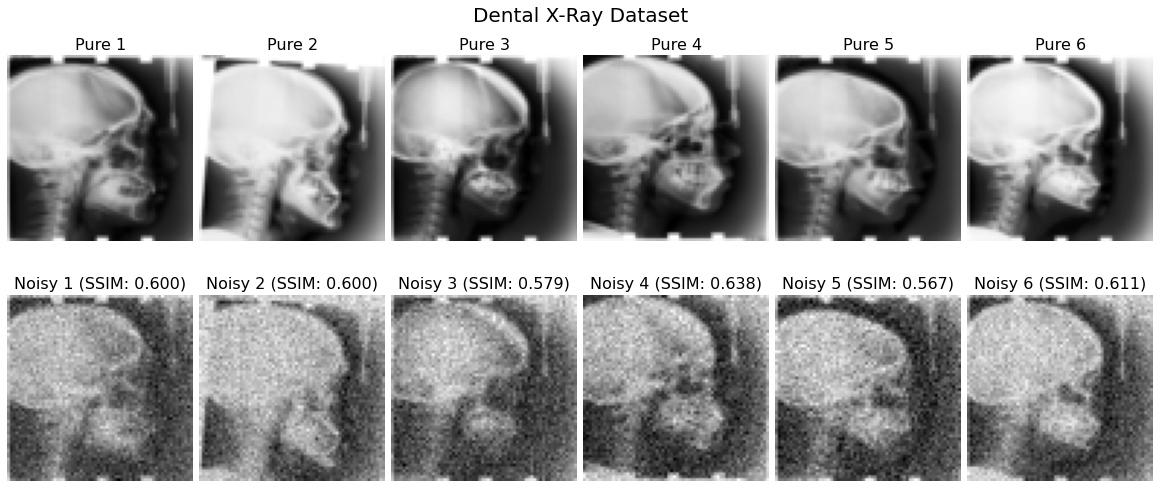

In [5]:
fig, axes = plt.subplots(2, 6, figsize=(16, 7), constrained_layout=True)
axes = list(map(list, zip(*axes)))
fig.suptitle("Dental X-Ray Dataset", fontsize=20)

for i, (ax1, ax2) in enumerate(axes):
    pure_img, _ = train_dataset[i]
    pure_img = pure_img.permute(1, 2, 0)

    ax1.imshow(pure_img, cmap="gray")
    ax1.axis("off")
    ax1.set_title(f"Pure {i+1}", fontsize=16)

    noisy_img = add_noise(pure_img)
    ssim_val = ssim(pure_img, noisy_img)
    ax2.imshow(noisy_img, cmap="gray")
    ax2.axis("off")
    ax2.set_title(f"Noisy {i+1} (SSIM: {ssim_val:.3f})", fontsize=16)

fig.savefig(DENTALXRAY_RESULTS_DIR / "dataset_sample.png", facecolor="w", transparent=False)


### Build & Train CNN based AutoEncoder Model

In [9]:
model = AutoEncoderCNN()
model.to(device)
print(model)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

train_losses = train(
    model,
    train_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=100,
    device=device,
    save_dir=DENTALXRAY_MODEL_DIR,
)


AutoEncoderCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Upsample(scale_factor=2.0, mode=nearest)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
)


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(DENTALXRAY_RESULTS_DIR / "train_loss.png", facecolor="w", transparent=False)


### Test the model


In [10]:
model = AutoEncoderCNN()
model.load_state_dict(torch.load(DENTALXRAY_MODEL_DIR / "autoencodercnn_epoch_100.pth"))
model.to(device)

noisy_imgs, denoised_imgs = test(model, test_loader, criterion=criterion, device=device)


C:\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Average test loss: 0.052509


### Visualize results

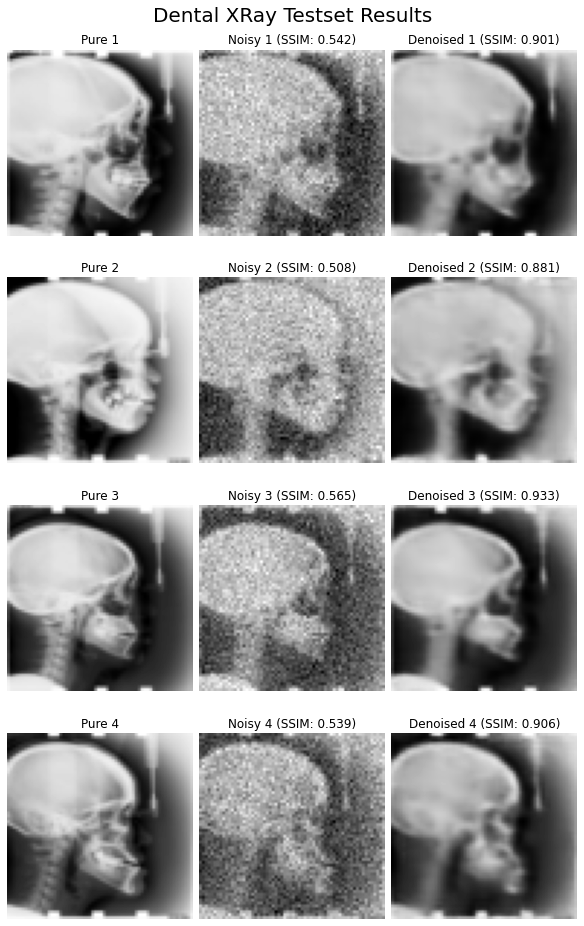

In [12]:
fig, axes = plt.subplots(4, 3, figsize=(8, 13), constrained_layout=True)
fig.suptitle("Dental XRay Testset Results", fontsize=20)

for i, ax in enumerate(axes):
    pure_img = test_dataset[i][0].permute(1, 2, 0)
    noisy_img = noisy_imgs[i].permute(1, 2, 0)
    denoised_img = denoised_imgs[i].permute(1, 2, 0)

    ssim_noisy = ssim(pure_img, noisy_img)
    ssim_denoised = ssim(pure_img, denoised_img)

    ax[0].imshow(pure_img, cmap="gray")
    ax[0].axis("off")
    ax[0].set_title(f"Pure {i+1}")

    ax[1].imshow(noisy_img, cmap="gray")
    ax[1].axis("off")
    ax[1].set_title(f"Noisy {i+1} (SSIM: {ssim_noisy:.3f})")

    ax[2].imshow(denoised_img, cmap="gray")
    ax[2].axis("off")
    ax[2].set_title(f"Denoised {i+1} (SSIM: {ssim_denoised:.3f})")

fig.savefig(DENTALXRAY_RESULTS_DIR / "results.png", facecolor="w", transparent=False)
